This notebook is designed to demonstrate how to produce plots for airborne EM (line data) and induction (point data) on a vertical section. We compare AEM conductvitiy inversions from a 1D-inversion (stored as netcdf file produced using geophys_utils) and 3D-inversions (stored as asci xyx file).

Neil Symington neil.symington@ga.gov.au

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import hydrogeol_utils.plotting_utils as plot_utils
import os, glob
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
import netCDF4
import math
import os
import gc
from scipy.interpolate import griddata
import numpy as np
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import spatial_function
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import Rectangle

C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ImportError: cannot import name 'spatial_function'

In [ ]:
def parse_misfit_files(lm_file, hm_file):
    
    hm_misfits = np.loadtxt(hm_file)

    lm_misfits = np.loadtxt(lm_file)
    
    # Dictionary for misfit data
    misfits = {}

    # Check that the coordinates are the same

    assert np.unique(hm_misfits[:,:2] == lm_misfits[:,:2])

    misfits['easting'] = hm_misfits[:,0]
    misfits['northing'] = hm_misfits[:,1]
    misfits['distance_along_line'] = coords2distance(hm_misfits[:,:2])
    misfits['hm_misfits'] = hm_misfits[:,2]
    misfits['lm_misfits'] = lm_misfits[:,2]

    # Calculate a normalised data misfit
    n_lmgates = EM_dataset.dimensions['low_moment_gate'].size
    n_hmgates = EM_dataset.dimensions['high_moment_gate'].size
    n_gates = n_lmgates + n_hmgates

    misfits['data_misfits'] = (n_lmgates/n_gates * misfits['lm_misfits']) + (n_hmgates/n_gates * misfits['hm_misfits'])
    
    # Reverse if need be
    
    if misfits['easting'][0] > misfits['easting'][-1]:
        for item in misfits:
            misfits[item] = misfits[item][::-1]
    
    return misfits

In [2]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

#ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\OrdBonaparte_nbc_borehole_constrained\delivered_03_12_18\netcdf'
ncdir = r"D:\GA\OB_AEM\inversions\netcdf"


# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdBon2019_DataResp_cord2dLogKeep.nc')
ob_dat = netCDF4.Dataset(EM_path)


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdBon2019_ModelExp_cord2dLogKeep.nc')
ob_cond = netCDF4.Dataset(cond_path)


In [4]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf'

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdKeep2019_DataResp_cor2DLogOrd.nc')
ek_dat = netCDF4.Dataset(EM_path)


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
ek_cond = netCDF4.Dataset(cond_path)


In [4]:
# GRid the 3D inversion data from xyz file

#indir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\delivered\20190428"
indir = r"C:\GA\cgi"


CGI_gridded_data = {}

for dirpath, dirnames, filenames in os.walk(indir):
    
    for filename in [f for f in filenames if f.endswith('_xyzzc.txt')]:
        print(filename)
        file = os.path.join(dirpath, filename)
    
        line= int(filename.split('_')[1][1:])
    
        CGI_conductivity = AEM_utils.parse_gridded_conductivity_file(file, ['easting', 'northing', 'elevation_centre',
                                                           'elevation', 'conductivity'], null=1e-08)
    
        CGI_gridded_data[line] = AEM_utils.griddify_xyz(CGI_conductivity)
    
lines = list(CGI_gridded_data.keys())


Bonaparte_L106001_unfilt_xyzzc.txt
Bonaparte_L106101_unfilt_xyzzc.txt


In [5]:
# Create an instance of plots for gridding the data
plots = plot_utils.ConductivitySectionPlot(ob_cond, ob_dat)

# Define some key variables which we want to inteprolate

plots.conductivity_variables = ['conductivity', 'data_residual', 'depth_of_investigation',
                               'easting', 'northing']

plots.EM_varibles  = ['data_values_by_low_moment_gate', 'data_values_by_high_moment_gate', 
                       'data_response_by_low_moment_gate', 'data_response_by_high_moment_gate']


# Define the resolution of th sections
xres, yres = 10., 3.

In [6]:
# Grid the line but leave it in memory
gridded_variables = plots.grid_variables(xres = xres, yres =yres, lines=list(lines), smoothed=False,
                                          resampling_method = 'linear', save_hdf5 = False, return_dict = True)

In [7]:
gridded_variables

{106001: {'conductivity': array([[       nan,        nan,        nan, ...,        nan,        nan,
                 nan],
         [       nan,        nan,        nan, ...,        nan,        nan,
                 nan],
         [       nan,        nan,        nan, ...,        nan,        nan,
                 nan],
         ...,
         [0.02480537, 0.02463753, 0.02397667, ...,        nan,        nan,
                 nan],
         [0.02480537, 0.02463753, 0.02397667, ...,        nan,        nan,
                 nan],
         [0.02480537, 0.02463753, 0.02397667, ...,        nan,        nan,
                 nan]], dtype=float32),
  'data_residual': array([2.02877614, 1.91785262, 1.80602876, ..., 3.26768519, 3.74813657,
         4.56400013]),
  'depth_of_investigation': array([464.14001465, 464.14001465, 464.14001465, ..., 399.97000122,
         399.97000122, 399.97000122]),
  'easting': array([460388.24796321, 460397.65443541, 460407.05114284, ...,
         480968.80438482, 480977

In [8]:
# Now bring in the data misfits from a separate file

CGI_misfits = {}

for hm_file in glob.glob('HM_output*'):
    lm_file = hm_file.replace('HM','LM')
    line = int(lm_file.split('_')[2].split('.')[0][1:])

    CGI_misfits[line] = parse_misfit_files(lm_file, hm_file)



In [11]:
# Bring in the induction data from spatialite database to pandas dataframe

#DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite"
DB_PATH = r"D:\GA\boreholes\compilation\spatialite\East_Kimberley_borehole_data.sqlite"
    
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()

query = 'SELECT b.* from borehole b;'

df_header = pd.read_sql_query(query, connection)

print(df_header)

    borehole_id Borehole_name Alternative_name     Easting     Northing  \
0        621622       17BP01I             None  478993.383  8335027.204   
1        621623       17BP03I             None  469012.153  8340498.650   
2        621624       17BP04I             None  462705.715  8344019.122   
3        621625       17BP05I             None  461179.050  8347241.926   
4        626981      RN029663             None  509738.000  8297777.000   
5        626984      RN034821             None  514784.000  8313635.000   
6        626986      RN029660             None  500047.884  8295266.378   
7        626987      RN029665             None  512860.000  8302461.000   
8        626988      RN029653             None  514021.000  8301501.000   
9        626989      RN029656             None  504845.000  8293381.000   
10       626990      RN029666             None  518194.000  8307268.000   
11       626991      RN029662             None  500590.000  8288080.000   
12       626992      RN03

In [13]:
# For every bore we will find the distance and netcdf
# index for each borehole that is within 500 m of an AEM fiducial

aem_coords = np.hstack((gridded_variables[line]['easting'].reshape([-1,1]),
                        gridded_variables[line]['northing'].reshape([-1,1])))


distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']], aem_coords,
                                                        points_required = 1, max_distance = 500.)

In [14]:
enos = []

for i, (index, row) in enumerate(df_header.iterrows()):
    # If the distances are not infinite (i.e. the boreholes disatnce is greater
    # than the maximum)
    if np.isfinite(np.sum(distances[i])):
        enos.append(row.borehole_id)
        
        
# Extract the induction gamma based on the eno

df_induction = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity',
                                                         'borehole_id'], connection, enos,
                                                       verbose = True).dropna()

select t.Depth, t.Apparent_conductivity, t.borehole_id from induction_gamma_data t where t.borehole_id in ();


In [15]:
# The induction data is far too dense for plotting so we resample



df_induction_resampled = pd.DataFrame(columns=['borehole_id', 'X', 'Y', 'Depth', 'Apparent_conductivity'])

for item in df_induction['borehole_id'].unique():
    mask= df_induction['borehole_id'] == item
    break
    new_depths = np.arange(math.ceil(df_induction[mask]['Depth'].min()),
                           math.floor(df_induction[mask]['Depth'].max()),1.)
    
    # Create an array of resampled depths and values
    df_resampled = spatial_functions.interpolate_depth_data(df_induction[mask],'Apparent_conductivity', 
                                                            'Depth', new_depths = new_depths)
    
    df_resampled['borehole_id'] = item
    df_resampled['X'] = df_header[df_header['borehole_id'] == item]['Easting'].iloc[0]
    df_resampled['Y'] = df_header[df_header['borehole_id'] == item]['Northing'].iloc[0]
    df_induction_resampled = df_induction_resampled.append(df_resampled)
    
    

In [21]:
line = lines[1]

In [22]:
line

106101

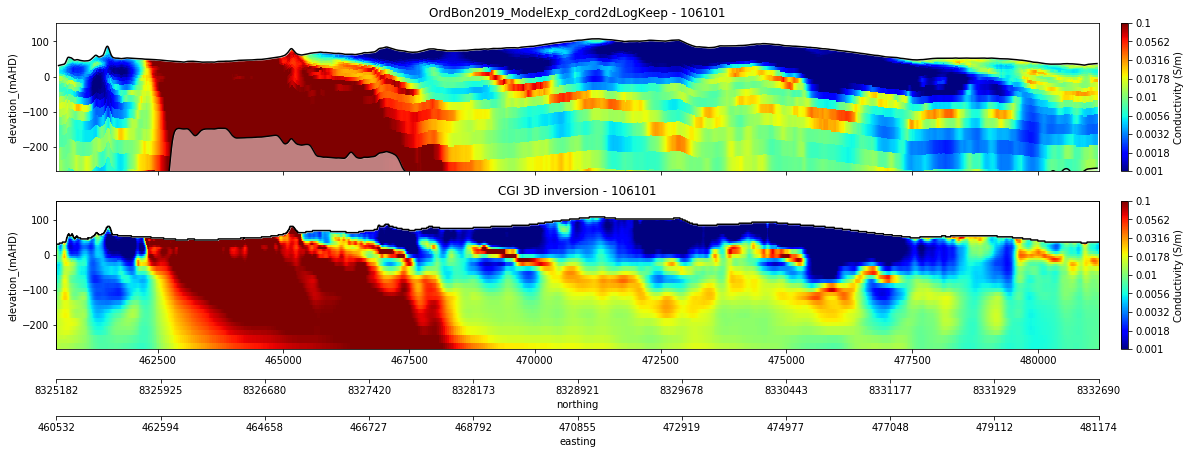

In [23]:

# Plot with linear stretch showing near surface
panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.1,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}


plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 6), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,'height_ratio')})


plot_utils.plot_grid(ax_array[0], gridded_variables[line], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[0], x_ax_var = 'easting')

# We will only plot certain bores

plot_utils.plot_grid(ax_array[1], CGI_gridded_data[line], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[1], x_ax_var = 'easting')


for bore in df_induction['borehole_id'].unique():
    
    mask = (df_induction_resampled['borehole_id'] == bore)

   
    for ax in ax_array:
        plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask], gridded_variables[line],
                                         'Apparent_conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=[0.001, 0.5], log_stretch = True, 
                                         max_distance=200., stick_thickness=200.)


    
ax_array[0].set_title("OrdBon2019_ModelExp_cord2dLogKeep - " + str(line))

ax_array[1].set_title("CGI 3D inversion - " + str(line))

ax_pos = plot_utils.align_axes(ax_array)

    # Add axis with northing at the bottom of the plot

plot_utils.add_axis_coords('northing', gridded_variables[line]['northing'], ax_array[-1], ax_pos[1], offset=-0.2)

plot_utils.add_axis_coords('easting', gridded_variables[line]['easting'], ax_array[-1], ax_pos[1], offset=-0.45)

#outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\delivered\20190428\sections"
outdir = r"C:\GA\cgi\sections"


outfile = os.path.join(outdir, str(line) + "_comparison_plot_log.png")

plt.savefig(outfile, dpi=300)

plt.show()

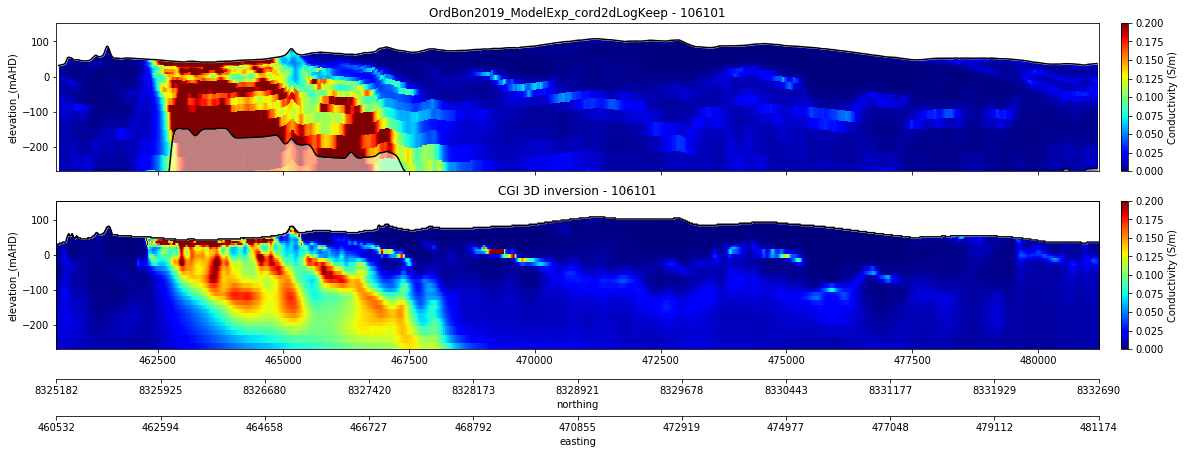

In [24]:

# Plot with linear stretch showing near surface
panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.2,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth':300, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.2,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}


plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 6), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,'height_ratio')})

plot_utils.plot_grid(ax_array[0], gridded_variables[line], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[0], x_ax_var = 'easting')

# We will only plot certain bores


plot_utils.plot_grid(ax_array[1], CGI_gridded_data[line], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[1], x_ax_var = 'easting')


for bore in df_induction['borehole_id'].unique():
    
    mask = (df_induction_resampled['borehole_id'] == bore)

   
    for ax in ax_array:
        plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask], gridded_variables[line],
                                         'Apparent_conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=[0.001, 0.5], log_stretch = True, 
                                         max_distance=200., stick_thickness=200.)


    
ax_array[0].set_title("OrdBon2019_ModelExp_cord2dLogKeep - " + str(line))

ax_array[1].set_title("CGI 3D inversion - " + str(line))

ax_pos = plot_utils.align_axes(ax_array)

    # Add axis with northing at the bottom of the plot

plot_utils.add_axis_coords('northing', gridded_variables[line]['northing'], ax_array[-1], ax_pos[1], offset=-0.2)

plot_utils.add_axis_coords('easting', gridded_variables[line]['easting'], ax_array[-1], ax_pos[1], offset=-0.45)

#outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\delivered\20190428\sections"

outfile = os.path.join(outdir, str(line) + "_comparison_plot_linear.png")

plt.savefig(outfile, dpi=300)

plt.show()